# Preprocessing the Yelp Comments on Berlin Restaurants

#### Get required packages

In [5]:
import pandas as pd
import re
import nltk
import string
import nltk.tokenize
#Run in Terminal
#pip install spacy
#python -m spacy download de_core_news_md
import spacy as spacy
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('german')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Get dataset

In [13]:
yelp = pd.read_csv('../1_web_scraping/intermediary_outputs/german_merged.csv')
yelp.columns.values[0]="ID"
yelp = yelp.rename(columns={'Overall Rating':'Overall_Rating',
                                      "Total Reviews":'Total_Reviews',
                                      "Restaurant Name":"Restaurant_Name",
                                     "Price Range":"Price_Range"})
yelp.columns
yelp['ID'] = yelp['ID'].astype(int)
yelp['Comment'] = yelp['Comment'].astype(str)
yelp['Overall_Rating'] = yelp['Overall_Rating'].astype(float)
yelp['Date'] = yelp['Date'].astype('datetime64[ns]',"dd-MM-yyyy")
yelp.dtypes
print(yelp.info())



C:\Users\ana\AppData\Local\Temp\ipykernel_23144\455744550.py:11: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  yelp['Date'] = yelp['Date'].astype('datetime64[ns]',"dd-MM-yyyy")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9721 entries, 0 to 9720
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               9721 non-null   int32         
 1   Restaurant_Name  9721 non-null   object        
 2   Overall_Rating   9721 non-null   float64       
 3   Total_Reviews    9721 non-null   int64         
 4   Specialty        9721 non-null   object        
 5   Region           9721 non-null   object        
 6   Price_Range      9721 non-null   object        
 7   Author           9721 non-null   object        
 8   Comment          9721 non-null   object        
 9   Rating           9721 non-null   int64         
 10  Date             9721 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(6)
memory usage: 797.6+ KB
None


C:\Users\ana\AppData\Local\Temp\ipykernel_23144\455744550.py:11: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  yelp['Date'] = yelp['Date'].astype('datetime64[ns]',"dd-MM-yyyy")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9721 entries, 0 to 9720
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               9721 non-null   int32         
 1   Restaurant_Name  9721 non-null   object        
 2   Overall_Rating   9721 non-null   float64       
 3   Total_Reviews    9721 non-null   int64         
 4   Specialty        9721 non-null   object        
 5   Region           9721 non-null   object        
 6   Price_Range      9721 non-null   object        
 7   Author           9721 non-null   object        
 8   Comment          9721 non-null   object        
 9   Rating           9721 non-null   int64         
 10  Date             9721 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(6)
memory usage: 797.6+ KB
None


#### Remove Duplicates

In [14]:
print(len(yelp))
# Remove duplicates
yelp = yelp.drop_duplicates(subset=['Comment'], inplace=False)
print(len(yelp)) #15 duplicates found

9721
9706
9721
9706


#### Basic Cleaning

In [15]:
#remove pattern "Unknown" / "x Fotos" in Author - replace with None
yelp['Author'] = yelp.Author.where((yelp.Author == 'Unknown') | ('Foto' in yelp.Author), None)
yelp['Price_Range'] = yelp.Price_Range.where(yelp.Price_Range == 'Unknown', None)
#print(yelp[yelp.ID==1114])

def clean_text(text):
    #fix enter instead of punctuation or space but keep contiguous capitalization
    text = re.sub('(?<=.)(?=[A-Z][a-z])', r" ", text)
    #remove random urls w/o http
    text = re.sub('[\w]+\.[\w]+\/+[\w]+','',text)
    #remove URL with http
    text = re.sub(r'http\S+', '', text)
    #remove URL with www
    text = re.sub(r'www\S+', '', text)
    # add space after . to avoid word concatenation when user left no space after .
    text = re.sub(r'(?<=[.,)!])(?=[^\s])', r' ', text)
    # Remove Emoji chars
    emoticons = r'[\W]+(?::|;|=)(?:-)?(?:\)+|\(|D|P)'
    text = re.sub(emoticons, '' , text)
    #remove hashtags but leave the content of a hashtag in text
    text = re.sub(r"([#]+)", "", text)
    #remove @name shoutouts +  weird shoutouts with space between @ and name
    pattern_shoutout_one = r"((\w+|[^a-z])[@](\s+\w+|\w+|.*))"
    text = re.sub(pattern_shoutout_one, "",text)
    #Remove weird unicode characters such as U+2026
    text = re.sub(r'[^\x00-\x7FäöüÄÖÜß]+', '', text)
    # # remove hashtags and normal shoutouts with @
    # pattern_hashtags_shoutouts = r"([@#]\w+)"
    # text = re.sub(pattern_hashtags_shoutouts,"" ,text)

    #remove digits
    text = re.sub(r'[0-9]+', '', text)
    #remove 1 char words
    text = re.sub(r'\b\w{1}\b', ' ', text)
    #Remove punctuations etc.
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    #Convert to lowercase to maintain consistency
    text = text.lower()
    return text

df = yelp[['ID', 'Comment']]
pd.set_option('max_colwidth', 800)
yelp['Clean_Comment'] = yelp['Comment'].apply(lambda x: clean_text(x))

yelp['Comment'] = yelp.Comment.apply(lambda x: clean_text(x))
print("URL case")
print(yelp.Comment[0])
print(yelp.Comment[3562])
print("Emoji case")
print(yelp.Comment[28])
print(yelp.Comment[6])
print(yelp.Comment[226])
print(yelp.Comment[164])
print("Shoutouts")
print("1")
print(yelp.Comment[278])#remove comments in english
print("2")
print(yelp.Comment[2672])
print("3")
print(yelp.Comment[6434])
print("4")
print(yelp.Comment[2690])
print("Hashtags")
print(yelp.Comment[1134])#remove comments in english
print(yelp.Comment[4605])
print("Commentar 112 gelandetTolles")
print(yelp.Comment[112])
print(yelp.Comment[2680])

URL case
ich habe mir  bewertungen zu  restaurants auf  menulist angesehen und dieses  restaurant hatte gute  kritiken also habe ich es ausprobiert und es nicht bereut 
neue  homepage
Emoji case
der wohl verrückteste  kellner den ich je hatte aber eine einzigartige  kneipe die sich  hinter der  stadtklause versteckt  im  kellergewölbe kann man auch noch sitzen günstiges deutsches  essen und  bier in einem eigentlich so touristisch überfluteten  potsdamer  platz  ecke gerade bei den sonst so hohen  bierpreisen in der  umgebung des  sony  center liefert die  stadtklause eine  entspannung für den  geldbeutel  preis leistung stimmt
super leckeres  essen cooles  atmosphäre  gutes  bier leider keine ec  karten oder  kreditkarten aktzeptiert das ist ein bissle schade
mit  abstand das beste  schnitzel weit und breit  super nettes  ambiente und tolles  personal beim nächsten berlin besuch wieder  daumen hoch
beste  ramen die ich jemals gegessen habe ja es ist voll aber man wartet mi ich lange a

In [16]:
yelp.head()

,ID,Restaurant_Name,Overall_Rating,Total_Reviews,Specialty,Region,Price_Range,Author,Comment,Rating,Date,Clean_Comment
0,0,JOSEPH,4.5,6,Israelisch /,Mitte,Unknown,None,ich habe mir bewertungen zu restaurants auf menulist angesehen und dieses restaurant hatte gute kritiken also habe ich es ausprobiert und es nicht bereut,5,2022-10-26,ich habe mir bewertungen zu restaurants auf menulist angesehen und dieses restaurant hatte gute kritiken also habe ich es ausprobiert und es nicht bereut
1,1,JOSEPH,4.5,6,Israelisch /,Mitte,Unknown,None,das joseph ist ein ziemlich neues israelisches restaurant im modernen design es ist zwar nicht besonders kuschelig aber angenehm hell und hübsch eingerichtet mit schönen lampen der service ist ausgesprochen freundlich unkompliziert und aufmerksam besonders celina das essen kam schnell sah sehr appetitlich aus und so schmeckte es auch die israelischen starter kleinigkeiten und hauptspeisen haben uns sehr gut geschmeckt die preise sind angemessen und für berlin mitte nicht zu teuer wir waren nur etwas überrascht dass schon um sehr laute musik aufgelegt wurde wir konnten uns fast nicht mehr unterhalten am er tisch gegenüber auf anfrage wurde das etwas gedrosselt fazit wer israelische küche mag gutes preis leistungs verhältnis möchte mit blick auf die friedri...,4,2019-07-11,das joseph ist ein ziemlich neues israelisches restaurant im modernen design es ist zwar nicht besonders kuschelig aber angenehm hell und hübsch eingerichtet mit schönen lampen der service ist ausgesprochen freundlich unkompliziert und aufmerksam besonders celina das essen kam schnell sah sehr appetitlich aus und so schmeckte es auch die israelischen starter kleinigkeiten und hauptspeisen haben uns sehr gut geschmeckt die preise sind angemessen und für berlin mitte nicht zu teuer wir waren nur etwas überrascht dass schon um sehr laute musik aufgelegt wurde wir konnten uns fast nicht mehr unterhalten am er tisch gegenüber auf anfrage wurde das etwas gedrosselt fazit wer israelische küche mag gutes preis leistungs verhältnis möchte mit blick auf die friedri...
2,2,JOSEPH,4.5,6,Israelisch /,Mitte,Unknown,None,schalömchen scheiße haben wir uns heute koscher weggeknallt maria und joseph werden zum vorbild kellerinnen geben alles und saufen mehr als der gast als ich rein kam schlägt es wellen aber ich bin diesen sommer einfach lit as fuck und alle saufen mit mir ne geile crew ist die halbe miete hätte gerne mehr geferkelt aber war zu dicht,5,2019-10-18,schalömchen scheiße haben wir uns heute koscher weggeknallt maria und joseph werden zum vorbild kellerinnen geben alles und saufen mehr als der gast als ich rein kam schlägt es wellen aber ich bin diesen sommer einfach lit as fuck und alle saufen mit mir ne geile crew ist die halbe miete hätte gerne mehr geferkelt aber war zu dicht
3,3,JOSEPH,4.5,6,Israelisch /,Mitte,Unknown,None,essen war allenfalls ok muss ich nicht nochmal haben insgesamt war mein erlebnis im joseph sehr langweilig nachdem ich allein ins restaurant kam dauerte es erstmal bis ich begrüßt und platziert wirde das lokal war nicht voll die speisekarte auf englisch was mich in berlin mitte nicht wirklich verwundert ich bestellte einen grüne bohnen salat als vorspeise und danach einen grillspieß mit gemüse in der offenen küche zubereitet kam es nach wenigen minuten am tisch an sellerie und walnüsse die lt karte unter anderem in meinem wohl klingenden salat sein sollten fehlten der selbstgemachte bagel als beilage zum salat hingegen hat mir gut geschmeckt der grillspieß bestand aus kartoffel zwiebel aubergine paprika und zucchini gebettet auf stellenweise schwarz ...,2,2020-08-01,essen war allenfalls ok muss ich nicht nochmal haben insgesamt war mein erlebnis im joseph sehr langweilig nachdem ich allein ins restaurant kam dauerte es erstmal bis ich begrüßt und platziert wirde das lokal war nicht voll die speisekarte auf englisch was mich in berlin mitte nicht wirklich verwundert ich bestellte einen grüne bohnen salat als vorspei

,ID,Restaurant_Name,Overall_Rating,Total_Reviews,Specialty,Region,Price_Range,Author,Comment,Rating,Date,Clean_Comment
0,0,JOSEPH,4.5,6,Israelisch /,Mitte,Unknown,None,ich habe mir bewertungen zu restaurants auf menulist angesehen und dieses restaurant hatte gute kritiken also habe ich es ausprobiert und es nicht bereut,5,2022-10-26,ich habe mir bewertungen zu restaurants auf menulist angesehen und dieses restaurant hatte gute kritiken also habe ich es ausprobiert und es nicht bereut
1,1,JOSEPH,4.5,6,Israelisch /,Mitte,Unknown,None,das joseph ist ein ziemlich neues israelisches restaurant im modernen design es ist zwar nicht besonders kuschelig aber angenehm hell und hübsch eingerichtet mit schönen lampen der service ist ausgesprochen freundlich unkompliziert und aufmerksam besonders celina das essen kam schnell sah sehr appetitlich aus und so schmeckte es auch die israelischen starter kleinigkeiten und hauptspeisen haben uns sehr gut geschmeckt die preise sind angemessen und für berlin mitte nicht zu teuer wir waren nur etwas überrascht dass schon um sehr laute musik aufgelegt wurde wir konnten uns fast nicht mehr unterhalten am er tisch gegenüber auf anfrage wurde das etwas gedrosselt fazit wer israelische küche mag gutes preis leistungs verhältnis möchte mit blick auf die friedri...,4,2019-07-11,das joseph ist ein ziemlich neues israelisches restaurant im modernen design es ist zwar nicht besonders kuschelig aber angenehm hell und hübsch eingerichtet mit schönen lampen der service ist ausgesprochen freundlich unkompliziert und aufmerksam besonders celina das essen kam schnell sah sehr appetitlich aus und so schmeckte es auch die israelischen starter kleinigkeiten und hauptspeisen haben uns sehr gut geschmeckt die preise sind angemessen und für berlin mitte nicht zu teuer wir waren nur etwas überrascht dass schon um sehr laute musik aufgelegt wurde wir konnten uns fast nicht mehr unterhalten am er tisch gegenüber auf anfrage wurde das etwas gedrosselt fazit wer israelische küche mag gutes preis leistungs verhältnis möchte mit blick auf die friedri...
2,2,JOSEPH,4.5,6,Israelisch /,Mitte,Unknown,None,schalömchen scheiße haben wir uns heute koscher weggeknallt maria und joseph werden zum vorbild kellerinnen geben alles und saufen mehr als der gast als ich rein kam schlägt es wellen aber ich bin diesen sommer einfach lit as fuck und alle saufen mit mir ne geile crew ist die halbe miete hätte gerne mehr geferkelt aber war zu dicht,5,2019-10-18,schalömchen scheiße haben wir uns heute koscher weggeknallt maria und joseph werden zum vorbild kellerinnen geben alles und saufen mehr als der gast als ich rein kam schlägt es wellen aber ich bin diesen sommer einfach lit as fuck und alle saufen mit mir ne geile crew ist die halbe miete hätte gerne mehr geferkelt aber war zu dicht
3,3,JOSEPH,4.5,6,Israelisch /,Mitte,Unknown,None,essen war allenfalls ok muss ich nicht nochmal haben insgesamt war mein erlebnis im joseph sehr langweilig nachdem ich allein ins restaurant kam dauerte es erstmal bis ich begrüßt und platziert wirde das lokal war nicht voll die speisekarte auf englisch was mich in berlin mitte nicht wirklich verwundert ich bestellte einen grüne bohnen salat als vorspeise und danach einen grillspieß mit gemüse in der offenen küche zubereitet kam es nach wenigen minuten am tisch an sellerie und walnüsse die lt karte unter anderem in meinem wohl klingenden salat sein sollten fehlten der selbstgemachte bagel als beilage zum salat hingegen hat mir gut geschmeckt der grillspieß bestand aus kartoffel zwiebel aubergine paprika und zucchini gebettet auf stellenweise schwarz ...,2,2020-08-01,essen war allenfalls ok muss ich nicht nochmal haben insgesamt war mein erlebnis im joseph sehr langweilig nachdem ich allein ins restaurant kam dauerte es erstmal bis ich begrüßt und platziert wirde das lokal war nicht voll die speisekarte auf englisch was mich in berlin mitte nicht wirklich verwundert ich bestellte einen grüne bohnen salat als vorspei

#### Tokenization & Stopword Removal

In [17]:

def tokenize_and_remove_stopword(text):
    tokens = word_tokenize(text,language='german')
    text = " ".join([word for word in tokens if word not in stop_words])
    return text

yelp['Tokenized_Comment'] = yelp['Clean_Comment'].apply(lambda x: tokenize_and_remove_stopword(x))
print(yelp.Comment[7890])
print(yelp.Comment[112])

wir sind alle   monate in der  schnitzelei die sehr großen  schnitzel sind sehr lecker und die  karte ist kreativ zusammengestellt  insbesondere das kostenlose  begrüßungsbier und die deutschen  tapas heben die  schnitzelei nochmal von anderen  lokalen ab  zudem sind alle  bedienungen sehr freundlich und das  ambiente ist sehr angenehm
durch  zufall sind wir auf das  marral gelandet tolles  essen toller  service und alles auch noch zu einem guten  preis  wir kommen defintiv wieder
wir sind alle   monate in der  schnitzelei die sehr großen  schnitzel sind sehr lecker und die  karte ist kreativ zusammengestellt  insbesondere das kostenlose  begrüßungsbier und die deutschen  tapas heben die  schnitzelei nochmal von anderen  lokalen ab  zudem sind alle  bedienungen sehr freundlich und das  ambiente ist sehr angenehm
durch  zufall sind wir auf das  marral gelandet tolles  essen toller  service und alles auch noch zu einem guten  preis  wir kommen defintiv wieder


#### Lemmatisierung mit SpaCy

In [18]:
# https://blog.codecentric.de/natural-language-processing-basics
# https://textmining.wp.hs-hannover.de/Preprocessing.html
# https://nickyreinert.de/blog/2020/12/09/einfuehrung-in-stemming-und-lemmatisierung-deutscher-texte-mit-python/
# https://de.steadforce.com/blog/natural-language-processing-tools
# https://spacy.io/usage/linguistic-features#lemmatization

In [19]:
#pip install spacy
#python -m spacy download de_core_news_md

In [20]:
spc =  spacy.load(r'de_core_news_md')

def lemmatize_spc(tokenized_comment):

    tok_cmt_as_spacy_object = spc(tokenized_comment)
    text = " ".join([token.lemma_ for token in tok_cmt_as_spacy_object])
    return text.lower()
yelp['Lemmatized_Comment'] = yelp['Tokenized_Comment'].apply(lambda x: lemmatize_spc(x))





#### Drop Columns and Save to CSV

In [21]:
yelp.drop(["ID", "Restaurant_Name", "Overall_Rating", "Total_Reviews", "Specialty", "Region", "Author", "Date", "Price_Range"],inplace = True,axis = 1)
yelp.to_csv("cleaned_data_yelp.csv", index=False)

In [22]:
print(yelp['Lemmatized_Comment'][1:2])

1    joseph ziemlich neu israelisch restaurant modern design besonders kuschelig angenehm hell hübsch einrichten schön lampe service ausgesprochen freundlich unkompliziert aufmerksam besonders celina essen kommen schnell sehen appetitlich schmeckt israelisch starter kleinigkeit hauptspeise gut schmecken preis angemessen berlin mitte teuer überraschen schon laut musik auflegen werden können fast mehr unterhalt tisch gegenüber anfrage werden drosseln fazit wer israelisch küche mögen gut preis leistung verhältnis möchten blick friedrichstraße nett service gut aufheben
Name: Lemmatized_Comment, dtype: object


C:\Users\ana\AppData\Local\Temp\ipykernel_23144\4127828587.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(yelp['Lemmatized_Comment'][1:2])


1    joseph ziemlich neu israelisch restaurant modern design besonders kuschelig angenehm hell hübsch einrichten schön lampe service ausgesprochen freundlich unkompliziert aufmerksam besonders celina essen kommen schnell sehen appetitlich schmeckt israelisch starter kleinigkeit hauptspeise gut schmecken preis angemessen berlin mitte teuer überraschen schon laut musik auflegen werden können fast mehr unterhalt tisch gegenüber anfrage werden drosseln fazit wer israelisch küche mögen gut preis leistung verhältnis möchten blick friedrichstraße nett service gut aufheben
Name: Lemmatized_Comment, dtype: object


C:\Users\ana\AppData\Local\Temp\ipykernel_23144\4127828587.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(yelp['Lemmatized_Comment'][1:2])


# Data Visualization: Data Description and Distribution

[5, 4, 3, 2, 1]
5    4595
4    2762
3    1257
2     602
1     490
Name: Rating, dtype: int64


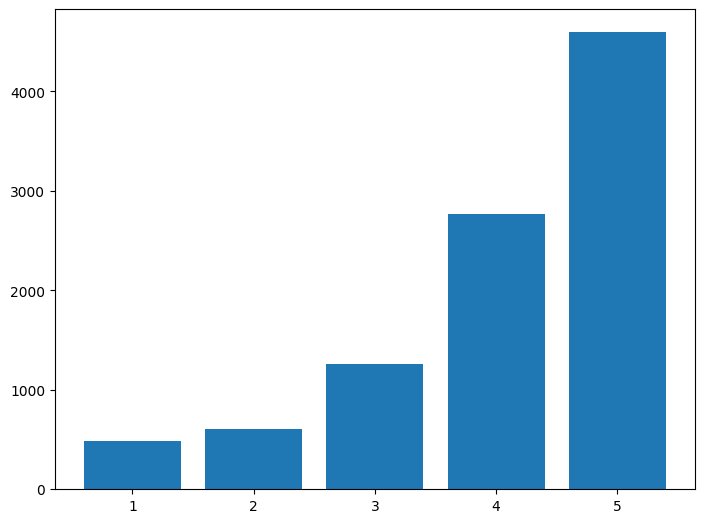

In [69]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = sorted(list(yelp['Rating'].unique()), reverse=True)
print(langs)
students =  (yelp['Rating'].value_counts())
print(students)
ax.bar(langs,students)
plt.show()

In [38]:
import numpy as np
# Get subset Datasets per Rating class for plots by class
# Count number of tokens per Comment
yelp = pd.read_csv('cleaned_data_yelp.csv')
def compute_length(text):
    tokens = nltk.word_tokenize(text)
    length_in_tokens = len(tokens)
    return length_in_tokens
yelp['Number_Tokens']= yelp['Tokenized_Comment'].apply(lambda x: compute_length(x))


yelp1 =pd.DataFrame(yelp[yelp.Rating==1])
yelp2 =pd.DataFrame(yelp[yelp.Rating==2])
yelp3 =pd.DataFrame(yelp[yelp.Rating==3])
yelp4 =pd.DataFrame(yelp[yelp.Rating==4])
yelp5 =pd.DataFrame(yelp[yelp.Rating==5])



In [39]:
# Get descriptive stats from Comment length
yelp['Number_Tokens'].describe()

count    9706.000000
mean       44.220070
std        43.364646
min         1.000000
25%        17.000000
50%        31.000000
75%        56.000000
max       417.000000
Name: Number_Tokens, dtype: float64

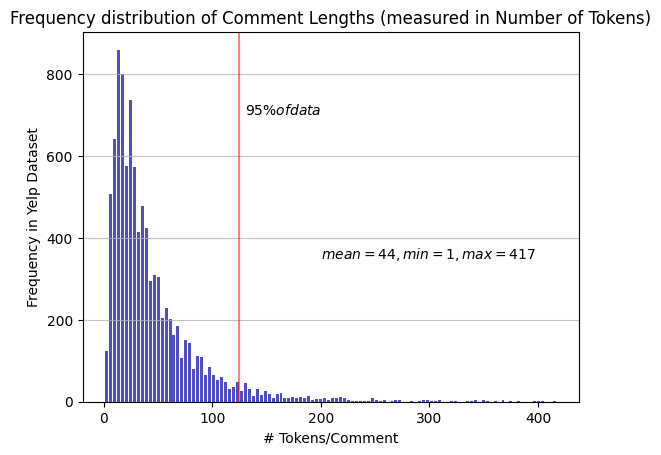

In [43]:
import matplotlib.pyplot as plt

## Create Plot
n, bins, patches = plt.hist(x=yelp.Number_Tokens, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.75)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('# Tokens/Comment')

q95= yelp['Number_Tokens'].quantile(q=0.95)
plt.axvline(q95, color='red',alpha=0.5)
plt.text(q95+5, 700, r'$95 \% of data$')

plt.ylabel('Frequency in Yelp Dataset')
plt.title('Frequency distribution of Comment Lengths (measured in Number of Tokens)')
plt.text(200, 350, r'$mean=44, min=1, max=417$')
maxfreq = n.max()
# Set a clean upper y-axis limit.

#### Comment length per Rating class

In [49]:
## Create Plot for Rating 1
yelp1.describe()

,Rating,Number_Tokens
count,490.0,490.000000
mean,1.0,59.402041
std,0.0,53.738932
min,1.0,1.000000
25%,1.0,22.000000
50%,1.0,42.000000
75%,1.0,81.000000
max,1.0,359.000000


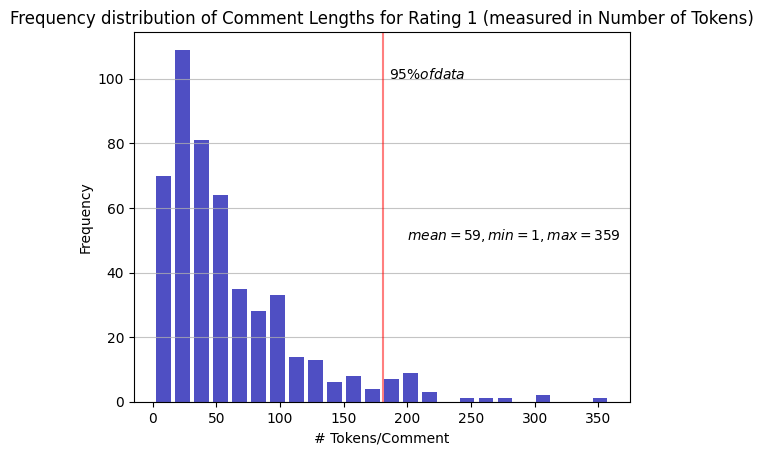

In [53]:
n, bins, patches = plt.hist(x=yelp1.Number_Tokens, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.75)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('# Tokens/Comment')

q95= yelp1['Number_Tokens'].quantile(q=0.95)
plt.axvline(q95, color='red',alpha=0.5)
plt.text(q95+5, 100, r'$95 \% of data$')

plt.ylabel('Frequency')
plt.title('Frequency distribution of Comment Lengths for Rating 1 (measured in Number of Tokens)')
plt.text(200, 50, r'$mean=59, min=1, max=359$')
maxfreq = n.max()

In [51]:
## Create Plot for Rating 2
yelp2.describe()

,Rating,Number_Tokens
count,602.0,602.000000
mean,2.0,60.870432
std,0.0,50.053381
min,2.0,2.000000
25%,2.0,26.000000
50%,2.0,46.000000
75%,2.0,79.000000
max,2.0,342.000000


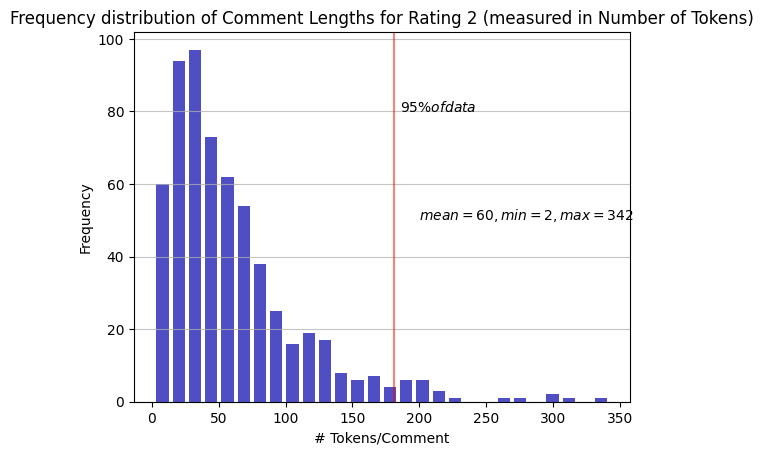

In [56]:
n, bins, patches = plt.hist(x=yelp2.Number_Tokens, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.75)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('# Tokens/Comment')

q95= yelp1['Number_Tokens'].quantile(q=0.95)
plt.axvline(q95, color='red',alpha=0.5)
plt.text(q95+5, 80, r'$95 \% of data$')

plt.ylabel('Frequency')
plt.title('Frequency distribution of Comment Lengths for Rating 2 (measured in Number of Tokens)')
plt.text(200, 50, r'$mean=60, min=2, max=342$')
maxfreq = n.max()

In [57]:
yelp3.describe()

,Rating,Number_Tokens
count,1257.0,1257.000000
mean,3.0,53.728719
std,0.0,45.407764
min,3.0,3.000000
25%,3.0,23.000000
50%,3.0,41.000000
75%,3.0,69.000000
max,3.0,381.000000


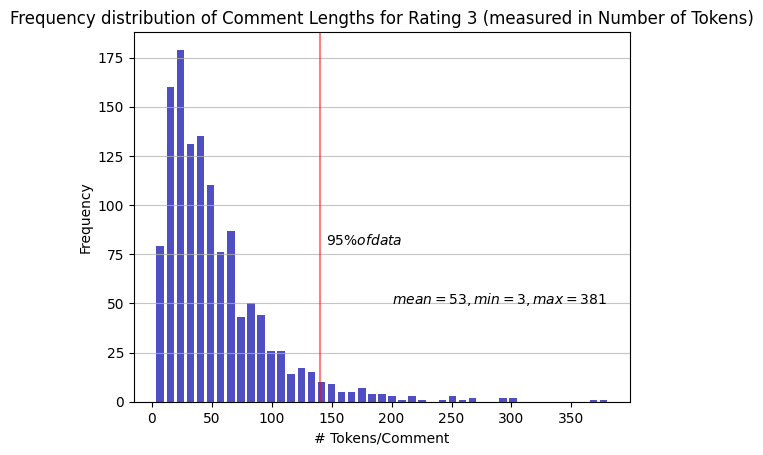

In [60]:
n, bins, patches = plt.hist(x=yelp3.Number_Tokens, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.75)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('# Tokens/Comment')

q95= yelp3['Number_Tokens'].quantile(q=0.95)
plt.axvline(q95, color='red',alpha=0.5)
plt.text(q95+5, 80, r'$95 \% of data$')

plt.ylabel('Frequency')
plt.title('Frequency distribution of Comment Lengths for Rating 3 (measured in Number of Tokens)')
plt.text(200, 50, r'$mean=53, min=3, max=381$')
maxfreq = n.max()

In [61]:
yelp4.describe()

,Rating,Number_Tokens
count,2762.0,2762.000000
mean,4.0,43.775887
std,0.0,42.529357
min,4.0,2.000000
25%,4.0,17.000000
50%,4.0,31.000000
75%,4.0,55.000000
max,4.0,403.000000


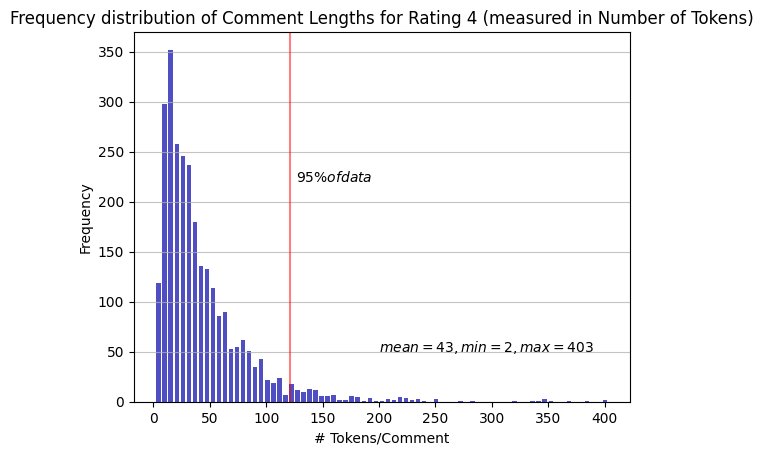

In [64]:
n, bins, patches = plt.hist(x=yelp4.Number_Tokens, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.75)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('# Tokens/Comment')

q95= yelp4['Number_Tokens'].quantile(q=0.95)
plt.axvline(q95, color='red',alpha=0.5)
plt.text(q95+5, 220, r'$95 \% of data$')

plt.ylabel('Frequency')
plt.title('Frequency distribution of Comment Lengths for Rating 4 (measured in Number of Tokens)')
plt.text(200, 50, r'$mean=43, min=2, max=403$')
maxfreq = n.max()

In [65]:
yelp5.describe()

,Rating,Number_Tokens
count,4595.0,4595.000000
mean,5.0,38.085528
std,0.0,39.538300
min,5.0,1.000000
25%,5.0,15.000000
50%,5.0,26.000000
75%,5.0,47.000000
max,5.0,417.000000


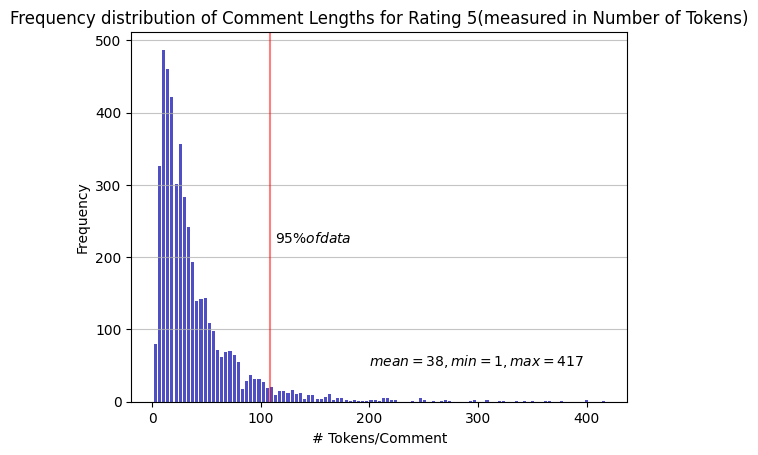

In [67]:
n, bins, patches = plt.hist(x=yelp5.Number_Tokens, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.75)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('# Tokens/Comment')

q95= yelp5['Number_Tokens'].quantile(q=0.95)
plt.axvline(q95, color='red',alpha=0.5)
plt.text(q95+5, 220, r'$95 \% of data$')

plt.ylabel('Frequency')
plt.title('Frequency distribution of Comment Lengths for Rating 5(measured in Number of Tokens)')
plt.text(200, 50, r'$mean=38, min=1, max=417$')
maxfreq = n.max()

### Word Clouds

1


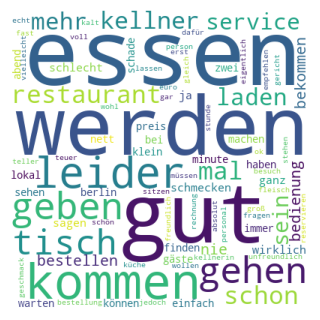

2


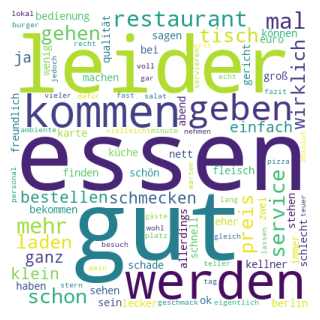

3


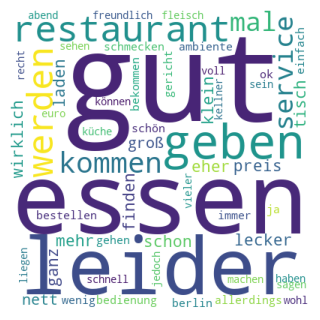

4


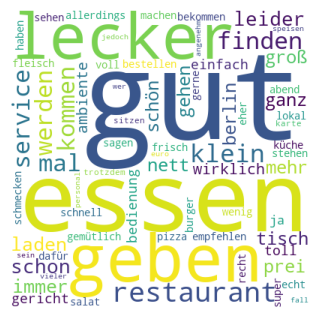

5


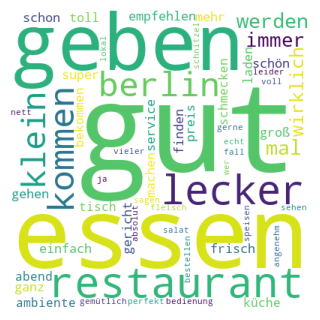

In [70]:
from wordcloud import WordCloud
def print_wordCloud(rating,comment):
    print(rating)
    wordcloud = WordCloud(width = 400, height = 400,
                          background_color ='white',
                          min_font_size = 10).generate(comment)
    plt.figure(figsize = (3, 3), facecolor = 'white', edgecolor='blue')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

def make_string(rating):
    summary_str = ""
    for row_index,row in yelp[yelp['Rating']==rating].iterrows():
        summary_str += " " + row['Lemmatized_Comment']
    return summary_str

ratings = sorted(yelp["Rating"].unique().tolist())
for rating in ratings:
    post_comment = make_string(rating)
    print_wordCloud(rating,post_comment)